# Consumer Complaint Classification


**The dataset represents consumer complaints about the number of products. Student loan and Bank account or service are products. The RNN has to classify consumer complaints are text data.**

# Installing Tensorflow==2.0.0

In [1]:
#!pip install tensorflow==2.8.0

#Importing The Libraries.

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import accuracy_score
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Activation,LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Embedding,SpatialDropout1D
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Connecting to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir("/content/drive/MyDrive/DeepL/11. Consumer Complaint Classification using RNN/dataset")

In [5]:
!dir


Consumer_Complaints\ (1).csv


#Loading Data

In [6]:
df_consumer_complaints = pd.read_csv("Consumer_Complaints (1).csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df_consumer_complaints.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,06/07/2019,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was already discharged in bankruptcy and ...,NaN,Company has responded to the consumer and the ...,Army and Air Force Exchange Service,AL,358XX,NaN,Consent not provided,Web,06/07/2019,Closed with explanation,Yes,NaN,3267335
1,06/07/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"Bank of CFPB, Washington, DC CFPB PIV",DC,20552,Servicemember,NaN,Web,06/07/2019,Closed with explanation,Yes,NaN,3267169
2,06/07/2019,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,NaN,Company believes it acted appropriately as aut...,Monterey Financial Services LLC,MN,55014,NaN,Consent not provided,Web,06/07/2019,Closed with explanation,Yes,NaN,3266966
3,06/07/2019,Debt collection,Other debt,Communication tactics,Frequent or repeated calls,NaN,NaN,ALLY FINANCIAL INC.,NJ,07103,NaN,NaN,Phone,06/07/2019,In progress,Yes,NaN,3267618
4,06/07/2019,Debt collection,Other debt,False statements or representation,Indicated you were committing crime by not pay...,NaN,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,071XX,NaN,NaN,Web,06/07/2019,Closed with explanation,Yes,NaN,3267687


In [8]:
df_consumer_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303617 entries, 0 to 1303616
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1303617 non-null  object
 1   Product                       1303617 non-null  object
 2   Sub-product                   1068451 non-null  object
 3   Issue                         1303617 non-null  object
 4   Sub-issue                     769820 non-null   object
 5   Consumer complaint narrative  384865 non-null   object
 6   Company public response       460903 non-null   object
 7   Company                       1303617 non-null  object
 8   State                         1283431 non-null  object
 9   ZIP code                      1185291 non-null  object
 10  Tags                          178463 non-null   object
 11  Consumer consent provided?    700309 non-null   object
 12  Submitted via                 1303617 non-

In [9]:
df_consumer_complaints.Product.value_counts()

Mortgage                                                                        279773
Debt collection                                                                 248580
Credit reporting, credit repair services, or other personal consumer reports    236660
Credit reporting                                                                140432
Credit card                                                                      89190
Bank account or service                                                          86206
Student loan                                                                     52166
Credit card or prepaid card                                                      49515
Checking or savings account                                                      42364
Consumer Loan                                                                    31605
Vehicle loan or lease                                                            11796
Money transfer, virtual currency, or money 

In [10]:
df_consumer_complaints.shape

(1303617, 18)

# Filtering observations and columns we wanted to train the model

In [11]:
# Merging some of observations which are same categories
df_consumer_complaints.loc[df_consumer_complaints['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df_consumer_complaints.loc[df_consumer_complaints['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df_consumer_complaints.loc[df_consumer_complaints['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df_consumer_complaints.loc[df_consumer_complaints['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df_consumer_complaints = df_consumer_complaints[df_consumer_complaints.Product != 'Other financial service']

In [12]:
# Filtering two columns one column is for input and another one is for output
df_consumer = df_consumer_complaints.loc[:,["Consumer complaint narrative","Product"]]


In [13]:
# Drop observations which is NAN
df_consumer  = df_consumer.dropna()

In [14]:
#Taking observations only three categories
df_Credit = df_consumer.loc[df_consumer['Product'] == "Credit card or prepaid card", :]
df_bank = df_consumer.loc[df_consumer['Product'] == "Bank account or service", :]
df_student = df_consumer.loc[df_consumer['Product'] == "Student loan", :]

# Merging observations of three categories
df_consumer =pd.concat([df_Credit,df_bank,df_student])

In [15]:
df_consumer.head()

,Consumer complaint narrative,Product
54389,Payments have been made and cleared on my XXXX...,Credit card or prepaid card
55097,On or about XX/XX/XXXX I submitted a complaint...,Credit card or prepaid card
55147,I wanted to make a payment on my due date of X...,Credit card or prepaid card
56059,On XX/XX/XXXX I had 5 separate charges from XX...,Credit card or prepaid card
56732,American Express closed my account based on an...,Credit card or prepaid card


In [16]:
df_consumer.shape

(77112, 2)

# Clearning the data set

**Junk data and punctuation marks an all....**

In [17]:
# Reset the index of dataframe
df_consumer = df_consumer.reset_index(drop=True)
# Create a pattern to filter
repalce_space = re.compile('[/(){}\[\]\|@,;]')
#remove_bad_symbols = re.compile('[^a-zA-Z ]')
remove_bad_symbols = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    #lowercase text
    text = text.lower() 
    # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = repalce_space.sub(' ', text)
    # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = remove_bad_symbols.sub('', text)  
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    # remove stopwors from text
    text = ' '.join(word for word in text.split() if word not in stop_words) 
    return text


In [18]:
# Clean the data set
df_consumer['Consumer complaint narrative'] = df_consumer['Consumer complaint narrative'].apply(clean_text)
df_consumer['Consumer complaint narrative'] = df_consumer['Consumer complaint narrative'].str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


# The Following code  creates word clouds from the dataset and visualize

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
stop_word = set(STOPWORDS)


def generate_wordcloud(text,title = None): 
    
    #Creating wordcloud object and getting list of frequent words from text
    wordcloud = WordCloud(background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          stopwords = stop_word,).generate(text)
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
   
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.show()



# Visualizing most frequent words in the "Credit card or prepaid card" category

In [20]:
df_Credit["Consumer complaint narrative"] = df_Credit["Consumer complaint narrative"].apply(clean_text)
df_Credit["Consumer complaint narrative"] = df_Credit["Consumer complaint narrative"].str.replace('\d+', '')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


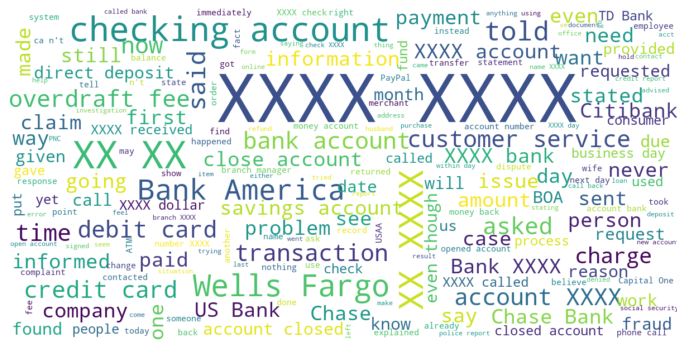

In [21]:
generate_wordcloud(' '.join(df_bank.iloc[:,0]))

We can notice that frequency words in "Credit card or prepaid card" category.

# Visualizing most frequent words in the "Bank account or service" category



In [22]:
df_bank["Consumer complaint narrative"] = df_bank["Consumer complaint narrative"].apply(clean_text)
df_bank["Consumer complaint narrative"] = df_bank["Consumer complaint narrative"].str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


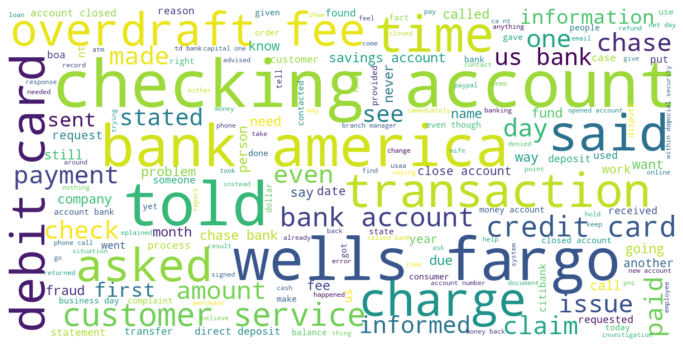

In [23]:
generate_wordcloud(' '.join(df_bank.iloc[:,0]))

We can notice that frequency words in "Bank account or service" category.

# Visualizing most frequent words in the "Student loan" category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


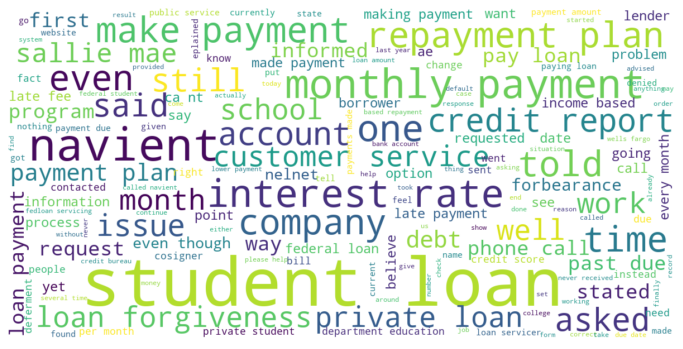

In [24]:
df_student["Consumer complaint narrative"] = df_student["Consumer complaint narrative"].apply(clean_text)
df_student["Consumer complaint narrative"] = df_student["Consumer complaint narrative"].str.replace('\d+', '')
generate_wordcloud(' '.join(df_student.iloc[:,0]))

We can notice that frequency words in "Student loan" category.

# Tokenizing the words

In [25]:
# The maximum number of words to be used. (most frequent)
max_no_words = 25000
# Max number of words in each complaint.
max_seq_len = 250
# Create tokenizer object
tokenizer = Tokenizer(num_words=max_no_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# Fit the tokenizer on text data
tokenizer.fit_on_texts(df_consumer['Consumer complaint narrative'].values)
# Count how many unique tokes are in these observations
word_index = tokenizer.word_index
print('Number of unique tokens %s' % len(word_index))

Number of unique tokens 60897


In [26]:
# Text to sequences 
X = tokenizer.texts_to_sequences(df_consumer['Consumer complaint narrative'].values)

# Padding the sequences
X = pad_sequences(X, maxlen=max_seq_len)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (77112, 250)


In [27]:
# Create dummies variables for output variable
Y = pd.get_dummies(df_consumer['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (77112, 3)


# Spilit the dataset into train and test dataset

In [48]:
#Traning and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42,stratify = Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(53978, 250) (53978, 3)
(23134, 250) (23134, 3)


# Model development with simple RNN

## Training the model

In [ ]:
#!pip install -U numpy==1.19.2

In [30]:
#Create sequential object
model = Sequential()
#Embedding layer
model.add(Embedding(max_no_words, 100, input_length=X.shape[1]))
#Dropout layer
model.add(SpatialDropout1D(0.2))
#RNN layer
model.add(SimpleRNN(100, input_shape = (53978,250), return_sequences = False))
#Fully connected layer
model.add(Dense(3))
model.add(Activation('softmax'))
#Optimizer 
adam = optimizers.Adam(lr = 0.001)
#Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
#Fit the model on the training dataset
history = model.fit(X_train, Y_train,epochs = 30, batch_size = 50, validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


972/972 [==============================] - 141s 144ms/step - loss: 0.5904 - accuracy: 0.7572 - val_loss: 0.5710 - val_accuracy: 0.8185
Epoch 2/30
972/972 [==============================] - 118s 121ms/step - loss: 0.4947 - accuracy: 0.8117 - val_loss: 0.5386 - val_accuracy: 0.7853
Epoch 3/30
972/972 [==============================] - 128s 132ms/step - loss: 0.4275 - accuracy: 0.8386 - val_loss: 0.4515 - val_accuracy: 0.8405
Epoch 4/30
972/972 [==============================] - 120s 123ms/step - loss: 0.3400 - accuracy: 0.8800 - val_loss: 0.5520 - val_accuracy: 0.8049
Epoch 5/30
972/972 [==============================] - 119s 123ms/step - loss: 0.5670 - accuracy: 0.7635 - val_loss: 0.9589 - val_accuracy: 0.6519
Epoch 6/30
972/972 [==============================] - 118s 122ms/step - loss: 0.5006 - accuracy: 0.8079 - val_loss: 0.7500 - val_accuracy: 0.6771


# Save the model

In [32]:
# Save the model
model.save('/content/drive/MyDrive/DeepL/11. Consumer Complaint Classification using RNN/model_rnn.h5')

# Testing the model

In [33]:
accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy [0],accuracy [1]))

723/723 [==============================] - 19s 26ms/step - loss: 0.7389 - accuracy: 0.6832
Test set
  Loss: 0.739
  Accuracy: 0.683


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
y_pred = model.predict(X_test)
y_test = np.argmax(Y_test, axis = -1)
#print(accuracy_score(y_pred, y_test))

confusion_matrix(y_test, y_pred)

**There are 4425 observations belongs to "bank account or service". In which, only  671 observations are correctly predicted**.

**There are 12158 observations belongs to "Credit card or prepaid card". In which, only 10338 observations are correctly predicted.**

There are 6551 observations belongs to "Student loan". In which, only 3865 observations are correctly predicted.


In [ ]:
labels = ['Bank account or service','Credit card or prepaid card','Student loan', ]
print(classification_report(y_test, y_pred, target_names=labels))

The RNN model predicts "Credit card or prepaid card " and "Student loan" observations correctly above 60 % of the f1 score. But the model did not perform poorly on "Banks account or service" category.

## Predictions

In [ ]:
# Single observation
x = np.reshape(X_test[0], (1,-1))
#Prediction on single observation
pred_observation = model.predict_classes(x)
labels = ['Bank account or service','Credit card or prepaid card','Student loan', ]
print(pred_observation[0], labels [pred_observation[0]])

# Visualizing "Loss" and "Accuracy" on each epoch

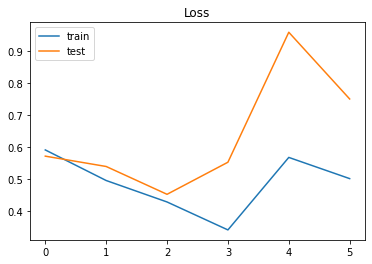

In [55]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

The plot shows the training and the testing loss on each epoch.

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['Acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

The plot shows the training and the testing accuracy on each epoch.

The RNN model classifies the customer complains at 64 % accuracy on the test dataset.